# Experiments

Necessary packages:
1. foreign
2. boot
3. AER (if in anaconda package manager, search 'r-aer')

## Randomized Controlled Trials

To better understand Randomized Controlled Trials, we will look at data from the Oregon Health Insurance Experiment (OHIE). This experiment looked to measure the treatment effect of Mdicaid elgibility. In the following dataset, person_id  is key. Treatment is in Description file, and is random conditional on the numhh_list (number of names in lottery). In 2008, new spots opened for medicaid, which was previously closed to new enroll. We are interested in health insurance effect on increased costs and utilization (on health is longer term). Aqdmin data is clean, survey data no necessarily balanced due to non-response bias
and admin data has hospital admission (by dept, emerg itself is non-signif). We can also look at number of hostpital days or total list cost.



In [1]:
#Set the working directory to the specific location of the files on your computer
#note: In this case, the working directory was set for my computer
setwd("/Users/Brandon/Harding_ML_Class")

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

In [2]:
#Get data

library(foreign)

descr <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_descriptive_vars.dta")
prgm <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_stateprograms_vars.dta")
s12 <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_survey12m_vars.dta")

### Prepare data for analysis

In [3]:
#Check that the id's match between imported data files
all(s12$person_id == descr$person_id)
all(s12$person_id == prgm$person_id)

#NOTE: Since both of the above statements are true, the id's between data files match exactly

[1] TRUE

[1] TRUE

In [4]:
#Pull a few rows from descr data set
P <- descr[,c("person_id","household_id", "numhh_list")]

#Create binary variable for enrolled in medicaid
P$medicaid <- as.numeric(prgm[,"ohp_all_ever_firstn_30sep2009"]=="Enrolled")

#Create binary variable for selected for treatment
P$selected <- as.numeric(descr[,"treatment"]=="Selected")

#Change factor levels for numh_list
levels(P$numhh_list) <- c("1","2","3+")

In [5]:
# Focus on 12 month is the survey that really matters
# need to control for household size interacted with survey return time

#Pull data from the s12 dataset
Y <- s12[,c("weight_12m",
    "doc_any_12m","doc_num_mod_12m",
    "er_any_12m","er_num_mod_12m",
    "hosp_any_12m","hosp_num_mod_12m")]

#Create some binary indicators
Y$doc_any_12m <- as.numeric(Y$doc_any_12m=="Yes")
Y$er_any_12m <- as.numeric(Y$er_any_12m=="Yes")
Y$hosp_any_12m <- as.numeric(Y$hosp_any_12m=="Yes")

In [6]:
# smk_ever_12m - num19_12m are sources of heterogeneity, plus descr
X <- s12[,121:147]
X$dt_returned <- factor(format(s12$dt_returned_12m, "%Y-%m"))

In [7]:
#Pull individuals for 12m mail survey response
insurv <- which(s12$sample_12m_resp == "12m mail survey responder")
X <- X[insurv,]
Y <- Y[insurv,]
P <- P[insurv,]

In [8]:
#Keep only individuals that responded to the survey
sapply(Y,function(y) sum(is.na(y)))
nomiss <- which( !apply(Y,1, function(y) any(is.na(y))) )
X <- X[nomiss,]
Y <- Y[nomiss,]
P <- P[nomiss,]

weight_12m      doc_any_12m  doc_num_mod_12m       er_any_12m 
               0              249              300              227 
  er_num_mod_12m     hosp_any_12m hosp_num_mod_12m 
             260              168              202

In [9]:
# pull out the weights and attach doc_any to P
weights <- Y[,1]
Y <- Y[,-1]

In [10]:
# replace some ridiculous values in survey and drop num19
X$hhsize_12m[X$hhsize_12m>10] <- 10
X$num19_12m <- NULL

In [11]:
# organize to make it pretty for text
P$doc_any_12m <- Y$doc_any_12m # you can explore other responses if you want
P <- P[,c(1,2,6,5,4,3)]
names(P)[6] <- "numhh"

In [12]:
#View cleansed data
head(P)
dim(P)

,person_id,household_id,doc_any_12m,selected,medicaid,numhh
1,1,100001,0,1,0,1
2,2,100002,0,1,1,1
5,5,100005,0,1,0,1
6,6,100006,1,1,0,1
8,8,102094,0,0,0,2
9,9,100009,1,0,0,1


[1] 23107     6

### Now that the data is cleansed, we will begin modeling a basic difference in means estimation. Our current treatment of interest is the selected variable and the response variable is doc_any_12m.

In [13]:
#Notice that approximately half of the individuals received the treatment
table(P$selected)


    0     1 
11629 11478 

In [14]:
##ATE estimation

#Calculate the means for control and treatment group
ybar <- tapply(P$doc_any_12m, P$selected, mean)

#Take difference in means between treatment groups
( ATE = ybar['1'] - ybar['0'] )

1 
0.05746606

#### Thus being selected in the medicaid application lottery gives you a roughly 6 percentage point increase in visiting a primary care physician (PCP).

#### To generate a confidence interval:

In [15]:
#Confidence interval for ATE
nsel <- table(P[,c("selected")])
yvar <- tapply(P$doc_any_12m, P$selected, var)
( seATE = sqrt(sum(yvar/nsel)) )

ATE + c(-2,2)*seATE

[1] 0.006428387

[1] 0.04460929 0.07032284

### Now calculate a weighted ATE for selected to compensate for heterogeneous treatment effects.

In [16]:
##ATE estimation for heterogeneous treatment effects

#Apply weights to individuals
nsel_w <- tapply(weights, P$selected, sum)

#Calculate control and treatment group means
ybar_w <- tapply(weights*P$doc_any_12m, P$selected, sum)/nsel_w

#Calculate ATE
( ATEweighted <-  ybar_w['1'] - ybar_w['0'] )

1 
0.05539111

### Return to unweighted ATE and calculate ATE for other respons evariables.

In [17]:
## unweighted analysis for all response options

#Calculate control and treatment group means for each response variable
ybar <- apply( Y, 2, function(y) tapply(y, P$selected, mean))

#Get number of individuals selected for treatment
nsel <- table(P[,c("selected")])

#Get control and treatment group variances
yvar <- apply( Y, 2, function(y) tapply(y, P$selected, var) )

#Print ATE for each response variable
print( gam <- ybar[2,]-ybar[1,] )

#Calculate standard deviation for ATE for each response variable
gsd <- sqrt(colSums(yvar/as.numeric(nsel)))
print( gam/gsd )



     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
    0.0574660650     0.2505294032    -0.0025271420    -0.0084462822 
    hosp_any_12m hosp_num_mod_12m 
    0.0005463461     0.0031396190 
     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
       8.9394217        6.6227586       -0.4433509       -0.6715141 
    hosp_any_12m hosp_num_mod_12m 
       0.1646074        0.6042924 


In [18]:
#No big difference if you use CLT on number of households r.t. people to generate standard deviation
nselhh <- tapply(P$household_id, P$selected, function(h) length(unique(h)))
gsdhh <- sqrt(colSums(yvar/as.numeric(nselhh)))
print( gam/gsdhh )

     doc_any_12m  doc_num_mod_12m       er_any_12m   er_num_mod_12m 
       8.4143417        6.2280826       -0.4172186       -0.6320600 
    hosp_any_12m hosp_num_mod_12m 
       0.1548938        0.5685051 


### We notice an interesting fact that health care consumption changes for indivduals depending on family. Can see in table below.

In [19]:
## consider the imbalance in numhh (number of members in household)

#Individuals in each treatment group is roughly balanced
table(P$selected)

#Household sizes as part of treatment groups
table(P[,c("selected","numhh")])


    0     1 
11629 11478 

        numhh
selected    1    2   3+
       0 8684 2939    6
       1 7525 3902   51

### If our response variable is still doc_any_12m, we can control for changes in y across treatment groups due to household size by adding a fixed effect in a regression. We are only able to control in this case because we know the factors that are causing a lack of balance between treatment groups.

In [20]:
#perform regression
lin <- glm(doc_any_12m ~ selected + numhh, data=P)

#View model summary with rounded items to 4 decimals
round( summary(lin)$coef,4) 

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.5902,0.0049,121.3655,0.0000
selected,0.0639,0.0065,9.9006,0.0000
numhh2,-0.0657,0.0071,-9.3049,0.0000
numhh3+,-0.1737,0.0648,-2.6811,0.0073


### Recall that the ATE estimate without controlling for household size was approximately 0.055, yet now the ATE is nearly 0.064.

### Now that we have begun to make model assumptions as a result of losing perfect randomization, let's see if more ssumptions can improve our model. We now think that the treatment effect of lottery selection is itself changing with the household size.

In [21]:
#Scale the model matrix such that covariates have mean 0
x <- scale( model.matrix( ~ numhh, data=P)[,-1], scale=FALSE)
colMeans(x)

numhh2       numhh3+ 
-3.723165e-17 -3.149334e-20

In [22]:
#Run the glm with the treatment and household size interaction
linadj <- glm(doc_any_12m ~ selected*x, data=P)

#View model summary
summary(linadj)


Call:
glm(formula = doc_any_12m ~ selected * x, data = P)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6579  -0.5868   0.3421   0.4132   0.8333  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.570410   0.004562 125.040  < 2e-16 ***
selected           0.064230   0.006460   9.943  < 2e-16 ***
xnumhh2           -0.051951   0.010407  -4.992 6.02e-07 ***
xnumhh3+          -0.420160   0.199162  -2.110   0.0349 *  
selected:xnumhh2  -0.025518   0.014173  -1.801   0.0718 .  
selected:xnumhh3+  0.272023   0.210619   1.292   0.1965    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2378277)

    Null deviance: 5536.2  on 23106  degrees of freedom
Residual deviance: 5494.1  on 23101  degrees of freedom
AIC: 32396

Number of Fisher Scoring iterations: 2


### Notice that the ATE estimate is practically unchanged from the previous model.

### Recall that the analysis above looks at the individual ATE, yet since the study includes indivduals from the same household, there is the possiblity of dependence between observations. Our point estimates are robust to this error, however our confidence intervals are not.

### We can generate good standard errors by estimating treatment effects at the household level. We will do this now, but first, the data must be prepared.

In [23]:
##Build the household effects

#Take the average number of doctor visits  for members of a household
yhh <- tapply(P$doc_any_12m, #column to perform function on
              P$household_id, #column to filter by
              mean #function to be performed
             )

#Pull 1st occurence of each HH in P
zebra <- match(names(yhh), P$household_id) 

#Get household indicies for those in treatment group
selectedhh <- P$selected[zebra]

#Pull household information for modeling
#note: this calls upon x, model matrix created above
xhh <- x[zebra,]

#Perform regression
summary(glm(yhh ~ selectedhh*xhh))


Call:
glm(formula = yhh ~ selectedhh * xhh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6579  -0.5868   0.3421   0.4132   0.4800  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.572661   0.004889 117.133  < 2e-16 ***
selectedhh             0.063291   0.006838   9.255  < 2e-16 ***
xhhnumhh2             -0.043883   0.012183  -3.602 0.000317 ***
xhhnumhh3+            -0.475715   0.273384  -1.740 0.081856 .  
selectedhh:xhhnumhh2  -0.029237   0.016467  -1.775 0.075835 .  
selectedhh:xhhnumhh3+  0.337775   0.289368   1.167 0.243109    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2241384)

    Null deviance: 4620.7  on 20475  degrees of freedom
Residual deviance: 4588.1  on 20470  degrees of freedom
AIC: 27495

Number of Fisher Scoring iterations: 2


### Also, we could decide to generate good standard errors without including a household comtrol in the regression by using the nonparametric bootstrap when we are concerned with dependence between observations.

### To perform the the nonparametric bootstrap, we need to resample at the household level to prevent the dependence between indivdual observations due to household assignment.

In [24]:
#Use boot library
library(boot)

In [25]:
#Get rows of matrix P
n <- nrow(P)

In [26]:
#Use split function to group individuals by their household id
# note: this is structured as a list and calling for example hhwho$10001 gives the indicies of
#       observations for that household
hhwho <- split(1:n, P$household_id)

In [27]:
#Crete function that will generate the desired metric for each bootstrapped sample
# In our case, we are looking to generate the treatment coefficient (that being selected) from the following regression in each sample
bootfit <- function(hhlist, boothh) {
    #Select all components of the hhwho list with specified household id's
    # and take the indicies of the observations within to coerce to vector
    bootsamp <- unlist(hhwho[boothh])
    #Perform regression on data P on the subsetted of rows using the sample of indicies created above in bootsamp
    boot_reg <-glm(doc_any_12m ~ selected*x, data = P, subset=bootsamp)
    #Pull the select coefficient from the regression
    coef(boot_reg)[2]
}

In [28]:
#Perform the bootstrap using the boot function from the boot library
bs <- boot(names(hhwho), #items to sample (in this case we are sampling the household id's yet recall these are the names of the list hhwho)
           bootfit, #function from above we are performing on each boostrap sample
           999 #numbe of bootstrap samples to generate
          )

In [29]:
#Get standard deviation of bootstrapped coefficients
sd(bs$t)

#Get quantiles for the coefficients
quantile(bs$t, c(.05,.95))

[1] 0.006657583

5%        95% 
0.05251998 0.07462240

#### Can also use clustered standard errors to approximate the bootstrap above.

In [30]:
#Use AER library
library(AER)

#The vcovCL will generate the clustered variances and taking the sqrt will get the answer
sqrt(vcovCL(linadj, cluster = P$household_id)[2,2])

Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:boot’:

    logit

Loading required package: lmtest
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:boot’:

    aml



[1] 0.006589621

### Using OLS can get a very robust estimate of treatment effects. However, to get treatment effects, must predict of covariate space for each treatment status, take difference in probabilities as treatment effect, and average results.

In [31]:
#Perform binary logistic regression on treatment (that being selected) and household size (that being numhh) and their interaction
lgt <- glm(doc_any_12m ~ selected*numhh, data=P, family="binomial")

In [32]:
#Create a data frame with all possible combinations in covariate space
predlocs <- data.frame(selected=c(1,1,1,0,0,0), 
    numhh=c('1','2','3+','1','2','3+'))

#View predlocs
predlocs

selected,numhh
1,1
1,2
1,3+
0,1
0,2
0,3+


In [33]:
#Make predictions on each combination in the covariate space
predy <- predict(lgt, newdata=predlocs, type='response')

#Take difference in predictions of response for each type of household
pdiff <- predy[1:3] - predy[4:6]
pdiff

1          2          3 
0.07111385 0.04559574 0.34313725

In [34]:
#Generate weights for amount of observations in each household type
mu_numhh <- table(P$numhh)/nrow(P)

In [35]:
#Take weighted average to find average treatment effects
# note: this uses matrix multiplication with the %*% operator
pdiff%*%mu_numhh

#NOTE: This value is very close to the OLS estimated ATE

0.06423005


## Near Experimental Designs

### Difference-In-Difference Regression (diff-in-diff)

We will an example of whether search egine marketing (SEM) is effective or not to study the idea of near experimental designs. Before performing the regression, some data celaning must be performed.

In [36]:
#Import the paidresearch.csv dataset
sem <- read.csv("paidsearch.csv")

#set graphical parameters (this is only needed for jupyter notebooks)
options(repr.plot.width = 10, repr.plot.height = 5)

In [37]:
#Change to data type: factor
sem$dma <- factor(sem$dma)

In [38]:
## quick summary: total revenue by date and treatment/controls
totalrev <- tapply(sem$revenue, sem[,c("date","search.stays.on")], sum)

In [39]:
## for plotting, we'll convert the row `dates' to R Date class
## see http://www.statmethods.net/input/dates.html for format codes.
asdate <- as.Date(rownames(totalrev), format="%d-%b-%y")

In [40]:
## order everything by date
totalrev <- totalrev[order(asdate),]
asdate <- sort(asdate)

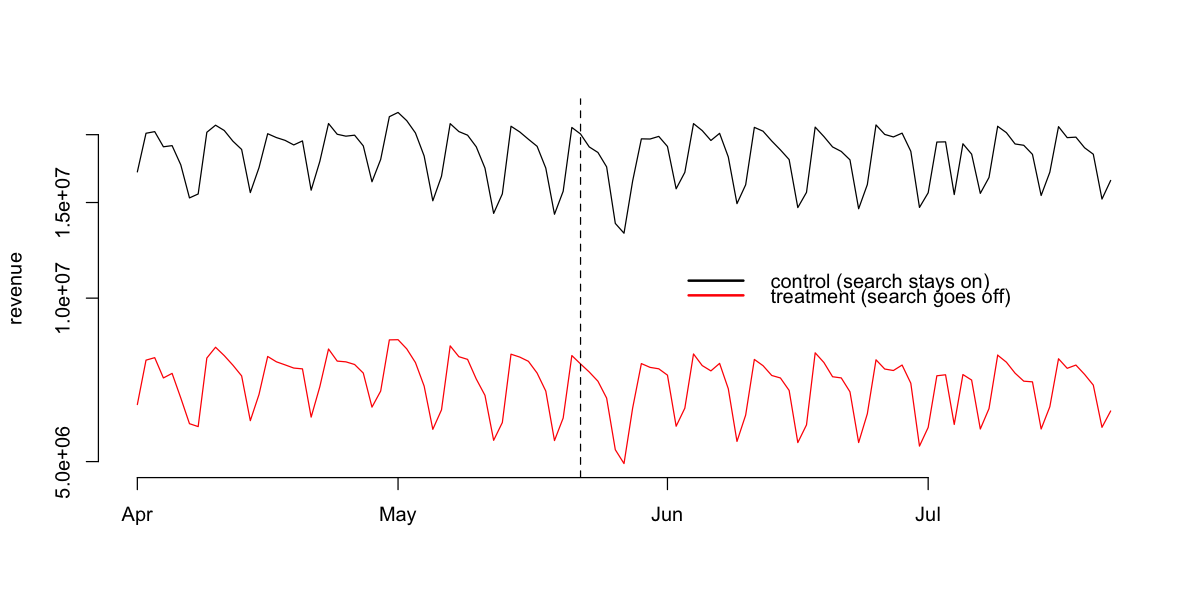

In [41]:
## plot the revenues by group
plot(asdate, totalrev[,'0'], type="l", bty="n", col=2,
    ylim=range(totalrev), log="y", xlab="", ylab="revenue")
lines(asdate, totalrev[,'1'], type="l")
legend("right",col=c(1,2), lwd=2, bty="n",
    legend=c("control (search stays on)", "treatment (search goes off)"))
abline(v=as.Date("2012-05-22"), lty=2)

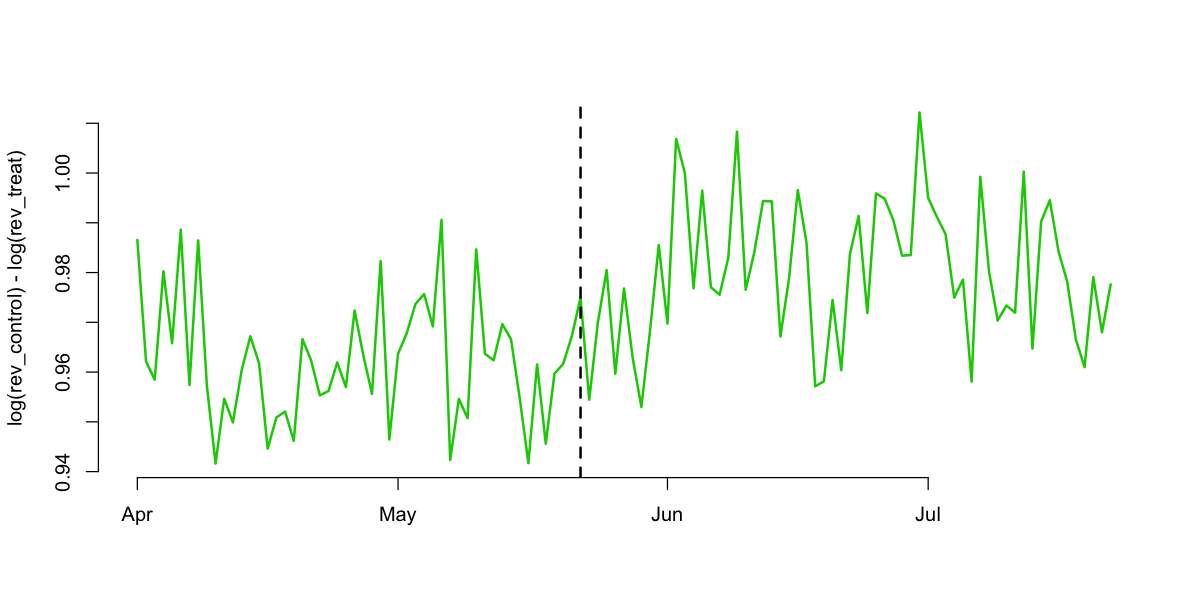

In [42]:
## Plot the difference between groups
plot(asdate, log(totalrev[,'1'])-log(totalrev[,'0']), 
    type="l", bty="n", col=3,lwd=2, xlab="", 
    ylab="log(rev_control) - log(rev_treat)")
abline(v=as.Date("2012-05-22"), lty=2,lwd=2)

In [43]:
#We'll now make use of the data.table library that makes it efficient to handle large datasets
library(data.table)

#Convert sem data frame to a data.table
sem <- as.data.table(sem)

#Adjust and transform variable values
semavg <- sem[, 
            list(d=mean(1-search.stays.on), y=mean(log(revenue))), 
            by=c("dma","treatment_period")]
setnames(semavg, "treatment_period", "t") # names to match slides

#Convert back to r data frame
semavg <- as.data.frame(semavg)
head(semavg)

dma,t,d,y
500,0,1,11.22800
501,0,0,14.58000
502,0,0,10.38516
503,0,0,10.48166
504,0,0,13.39498
505,0,1,12.81640


#### Now perform the follwoing regression

#### \begin{align} E[y_{it}] & = \alpha + d_i\beta_d + t\beta_t + \gamma d_i t \end{align}

In [44]:
#Perform regression
semreg <- glm(y ~ d*t, data=semavg)
summary(semreg)


Call:
glm(formula = y ~ d * t, data = semavg)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8518  -0.7061  -0.0447   0.7696   3.6521  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.948646   0.100495 108.948   <2e-16 ***
d            0.014081   0.176603   0.080    0.936    
t           -0.039400   0.142121  -0.277    0.782    
d:t         -0.006587   0.249754  -0.026    0.979    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1.434083)

    Null deviance: 596.77  on 419  degrees of freedom
Residual deviance: 596.58  on 416  degrees of freedom
AIC: 1349.3

Number of Fisher Scoring iterations: 2


In [45]:
#generate clustered standard errors
library(AER)
semreg_secl <- sqrt(vcovCL(semreg, cluster=semavg$dma)['d:t','d:t'])
semreg_secl

[1] 0.005534297

In [46]:
#For confidence interval
round(coef(semreg)["d:t"] + c(-2,2)*semreg_secl,4)

[1] -0.0177  0.0045

#### We can get similar results as above by controlling for the DMA-specific revenue levels in the regression equation itself (note this in the regression with alpha_i). Now perform the follwoing regression

#### \begin{align} E[y_{it}] & = \alpha_i + d_i\beta_d + t\beta_t + \gamma d_i t \end{align}

In [47]:
#Perform the regression
dmareg <- glm(y ~ dma + d*t, data=semavg)
summary(dmareg)$coef["d:t",]

Estimate   Std. Error      t value     Pr(>|t|) 
-0.006586852  0.005571899 -1.182155571  0.238493640

In [48]:
## just to confirm the regression results above 
##   we get the same thing just viewing this as a sample of n_dma differences.

#Calculate pre-post differences for each DMA
r <- tapply(semavg$y, semavg$dma, function(y) y[2]-y[1])

#Identify treatment and control groups
d <- semavg[match(names(r),semavg$dma),"d"]

#Compute average differences for treatment and control group
rbar <- tapply(r,d,mean)

#Compute rbar
rbar[2]-rbar[1]

#geberate rbar standard errors
rbarvar <- tapply(r, d, function(r) var(r)/length(r))
sqrt(sum(rbarvar))

1 
-0.006586852

[1] 0.005555082

### Regression Discontinuity Estimators

In these types of regressions (still near experimental design), we seek to control the forcing variable, the variable that is correlated with both treatment allocation and response.

In [49]:
#Load ad auction data
D <- read.csv("RD.csv")

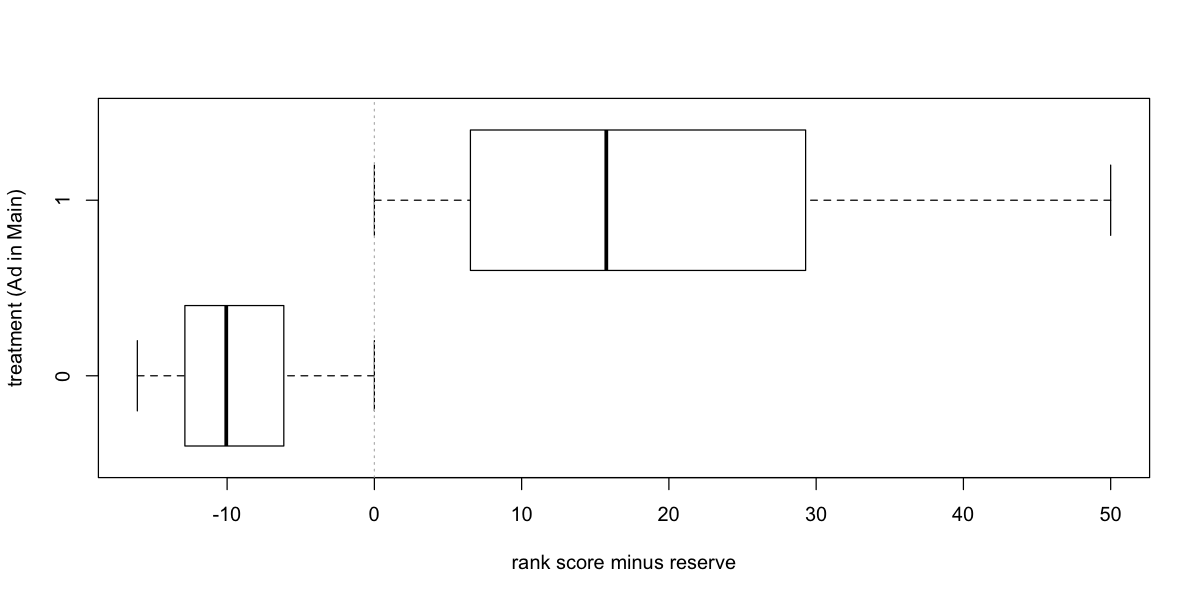

In [50]:
# We know that the variable rank score affects treament status (where th ead is placed)

#Plot treatment versus the forcing variable
boxplot(score ~ treat, data=D, horizontal=TRUE, 
    xlab="rank score minus reserve",
    ylab="treatment (Ad in Main)")
abline(v=0, col=8, lty=3)

#### Constant Model: Look at the mean response in a localized window around the discontinuity

In [51]:
# View a neighborhood of observations within 3 rank score units from discontinuity
w <- 3
above <- which(D$score > 0 & D$score <w)
below <- which(D$score < 0 & D$score >-w)

In [52]:
# constant model: take mean response for each window
mua <- mean(D$y[above])
mub <- mean(D$y[below])
(te <- mua - mub)

[1] 0.01484979

In [53]:
#Get variance for each window
vara <- var(D$y[above])
varb <- var(D$y[below])

#Get te standard error
sdte <- sqrt(vara/length(above) + varb/length(below))

#Compute a confidence interval
te + c(-2,2)*sdte

[1] 0.01305012 0.01664947

#### Localized Linear Regression: Fit a linear regression to each window

In [54]:
#Set window size
h <- 3

#Pull observations in window
window <- which(D$score > -h & D$score < h)

#Perform the regression
summary(linfit <- lm(y ~ treat*score, data=D, subset=window))


Call:
lm(formula = y ~ treat * score, data = D, subset = window)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09789 -0.06847 -0.03451  0.03188  1.20805 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0820048  0.0011768  69.682  < 2e-16 ***
treat       0.0119216  0.0017396   6.853  7.3e-12 ***
score       0.0006188  0.0006627   0.934     0.35    
treat:score 0.0007242  0.0010020   0.723     0.47    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1043 on 58414 degrees of freedom
Multiple R-squared:  0.00503,	Adjusted R-squared:  0.004978 
F-statistic: 98.43 on 3 and 58414 DF,  p-value: < 2.2e-16


In [55]:
##Generate standard errors for treatment effect

library(AER)
ate <- coef(linfit)["treat"]
seate <- sqrt(vcovHC(linfit)["treat","treat"])

#get confidence interval for treatment effect
ate + c(-2,2)*seate

[1] 0.00834634 0.01549686

In [56]:
#Make predictions in above and below window to be used for a plot
nr <- 10
rgrid <- seq(0, h, length=nr)
dgrid <- data.frame(score=c(-rev(rgrid),rgrid), 
                    treat=rep(c(0,1),each=nr))
linpred <- predict(linfit, newdata=dgrid)

#### Localized Linear Regression: Fit a weighted least squares regression to the window. Use the Loess smoother function.

In [57]:
#Perform weighted least squares regression for above window
fita <- loess(y ~ score, data=D[above,], degree=1)

#Perform weighted least squares regression for below window
fitb <- loess(y ~ score, data=D[below,], degree=1)
rr <- seq(0.001,w-0.001,length=100)

In [58]:
#Make predictions with regressions on value range rr below to be used for a plot
rr <- seq(0.001,w-0.001,length=100)
preda <- predict(fita,rr) 
predb <- predict(fitb,-rr)

#### The following plot:

On left: Plot y response on either side of the treatment threshold at zero.

On right: Plot of the conditional means using difference-in-means analysis, linear regression, and loess linear smoother for each side of zero.

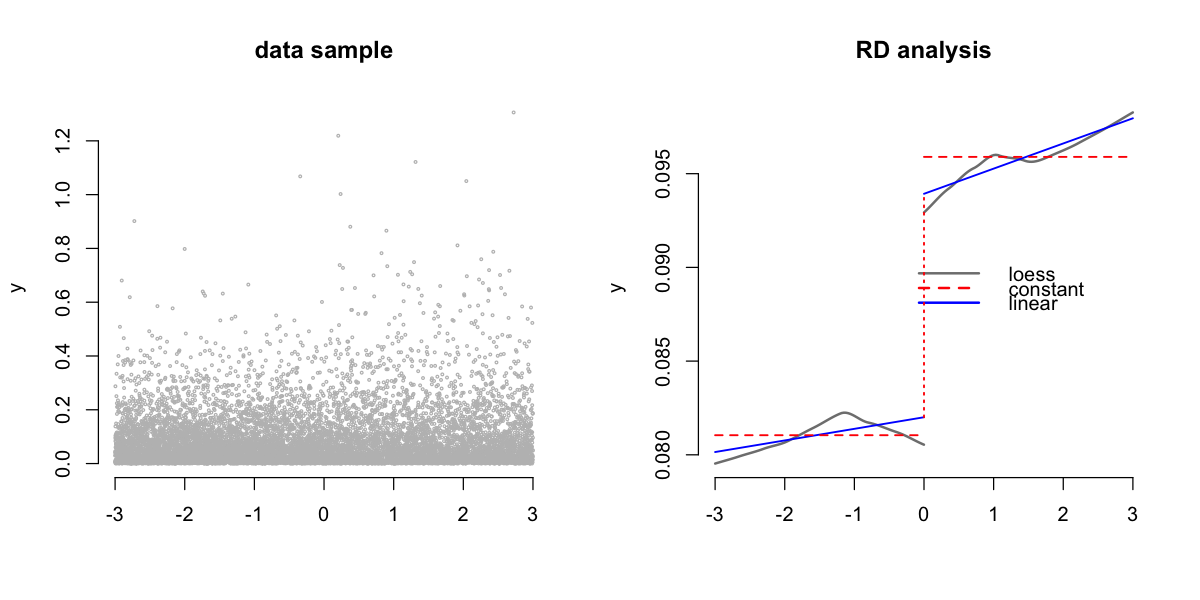

In [59]:
#Set plots side by side
par(mfrow=c(1,2))

#Left side plot
plot(y ~ score, data=D, subset=sample(c(above,below),10000), 
        cex=.3, col=8, bty="n", xlab="", main="data sample")

#Right Side plot
plot(rr, preda, xlab="", col="grey50", ylab="y",lwd=2, 
    main="RD analysis",
    ylim=range(c(preda,predb)), xlim=c(-w,w), type="l", bty="n")
legend("right", bty="n", lwd=2, lty=c(1,2,1), col=c("grey50","red","blue"), 
    legend=c("loess","constant","linear"))
lines(-rr, predb, col="grey50", lwd=2)
lines(dgrid$score[1:nr], linpred[1:nr], lwd=1.5, col=4)
lines(dgrid$score[nr+1:nr], linpred[nr+1:nr], lwd=1.5, col=4)
lines(dgrid$score[1:nr], rep(mub,nr), lwd=1.5, lty=2, col=2)
lines(dgrid$score[nr+1:nr], rep(mua,nr), lwd=1.5, lty=2, col=2)
lines(c(0,0),coef(linfit)[1] + c(0,coef(linfit)[2]), lwd=1.5, col=2, lty=3)
mtext(side=1, "rank score", outer=TRUE, line=1)

#### We can also look to calculate the RD treatment effect for a range of window sizes. The following is a plot showcasing the 90% confidence interval for the ATE estimate at a given window size.

In [60]:
##Estimate ATE at different window sizes with a for-loop

#Generate a vector of window sizes from 0.1 to 5 in increments of 0.1
hh <- seq(.1,5,length=50)

#Create two vectors to store the ATE point estimates (ateh) and Standard Errors (seah)
ateh <- seah <- rep(0,length(hh))

#Construct for loop to perform calculation of ate estimates and standard errors
for(i in 1:length(hh)){
    #Print window size we are calculating
    print(i)
    #Perform regression on subsample of data within the window size
    fith <- lm(y ~ treat*score, data=D, 
        subset=which(abs(D$score) < hh[i]))
    #Store the ATE estimate from teh regression
    ateh[i] <- coef(fith)[2]
    #Calculate and store teh standard error for t eATE coefficient
    seah[i] <- sqrt(vcovHC(fith)[2,2])
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50


In [61]:
#Compute the upper and lower confidence interval bounds for the ATE estimates
up <- ateh+2*seah
down <- ateh-2*seah

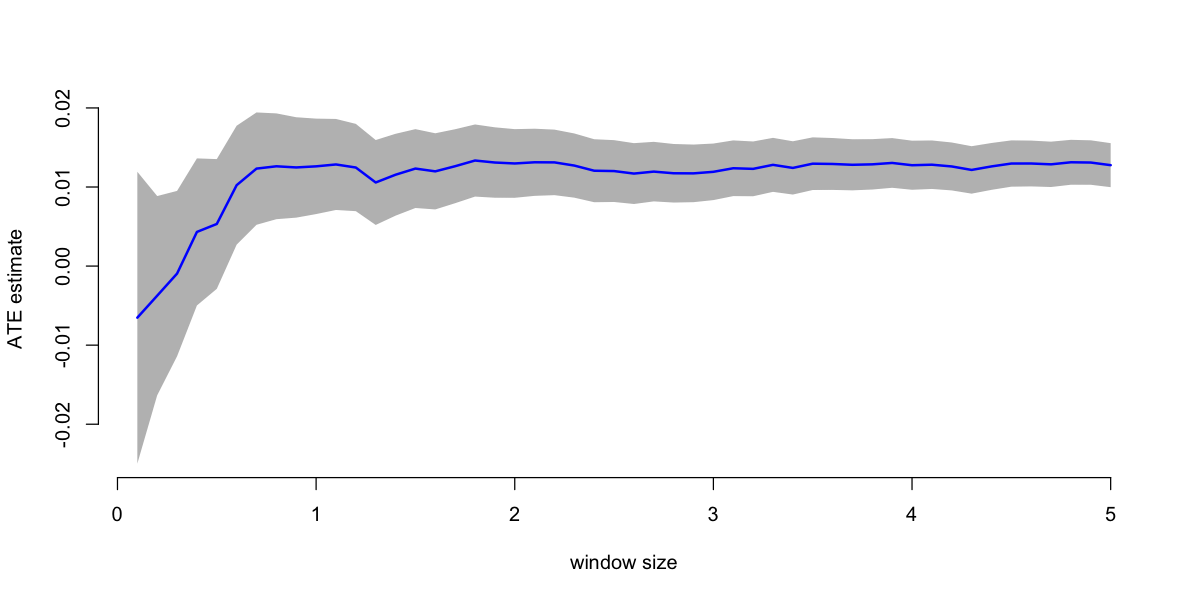

In [62]:
##Create plot

#Plot the ATE point estimates
plot(hh, ateh, type="l", ylim=range(c(up,down)), 
    xlab="window size", ylab="ATE estimate", bty="n")

#Shade in the 90% confidence interval for each point estimate
polygon(c(hh,rev(hh)), c(up,rev(down)), col=8, border=FALSE)

#Replot the ATE point estimates
lines(hh, ateh, col="blue", lwd=2)

## Instrumental Variables

To this point, we have estimated treatment effect for policies that are result of randomized trials. However, when we deal with estimation of treatment effects in which the the randomization occurs through experiments on variables (indirect randomization), different estimation techniques are need. Thus, the use of the Instrumental Variables (IV) are key.

To understand IV variables and their impact in regression analysis, we will generate a sample dataset to describe describe airline prices with sales and indicators for holidays and peak demand. In a sample example, if we attempted to regress prices on sales we would get an upward sloping demand curve. This is completely uninfromative. However, the use of the Two Stage Least Squares (2SLS) Regression technique can uncover the proper demand relationship. (Two Stage Least Squares will be explained in more detail shortly).

In [63]:
#Define a function that relates prices (p) and demand shocks (e) with sales
# note: as prices increase, sales should decrease
yfun <- function(e,p){
    y = 2 + 10*e-3*p + rnorm(length(e),0,.1)
    y[y<0] <- 0
    return(y)
}

In [64]:
##Generate data

#Create independent demand shocks
e <- rgamma(100,1,1)

#Create a set of prices observed using demand shocks (e) and an error term z
z <- rgamma(100,1,1)
pobs <- e + z

#Create a set of prices if a random experiment were run
pind <- rgamma(100,2,1)

#Feed both sets of prices into the sales function created above
yobs <- yfun(e, pobs)
yind <- yfun(e, pind)

In [65]:
#Perform 2SLS
preg <- lm(pobs ~ z)
phat <- predict(preg, data.frame(z=z))
lin2SLS <- lm(yobs ~ phat)

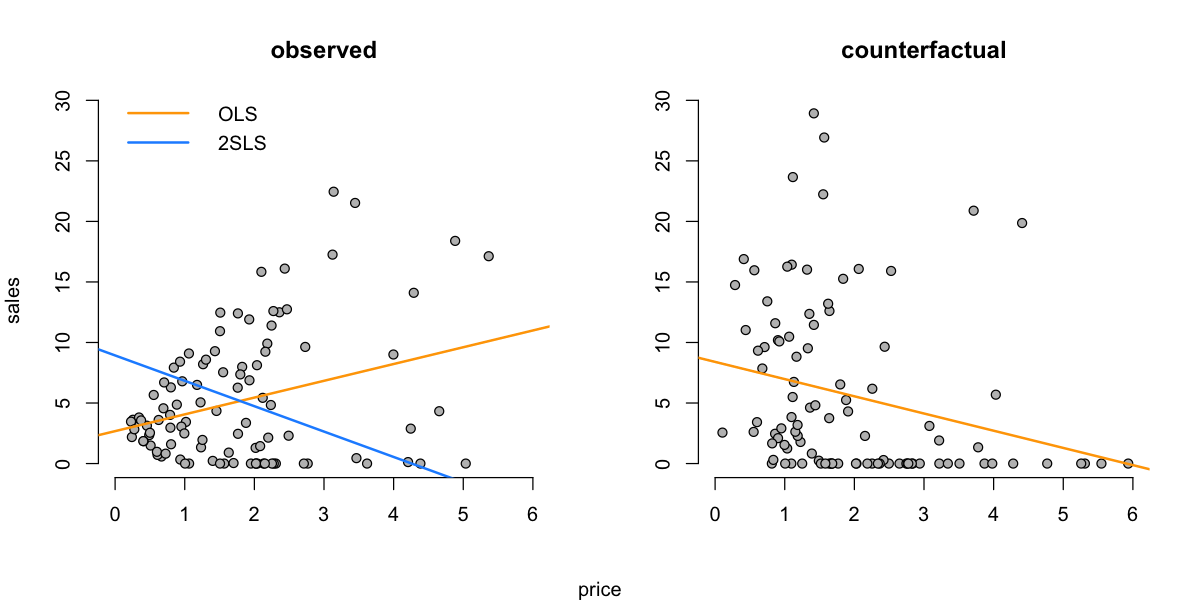

In [66]:
###Create two plots
par(mfrow=c(1,2))

##Left plot: Plot OLS and 2SLS lines with prices created endogenously

#Plot generated data
plot(pobs, yobs, xlim=c(0,6), ylim=c(0,29), pch=21, bg=8,
    xlab="", ylab="", 
    bty="n", main="observed")
#Add OLS line
abline(lm(yobs ~ pobs), col="orange", lwd=2)

#Add 2SLS line
abline(lin2SLS, col="dodgerblue", lwd=2)

#Format legend
legend("topleft", bty="n", legend=c("OLS","","2SLS"),
    lwd=2, col=c("orange","white","dodgerblue"))

##Right plot: Plot OLS for prices generated randomly independent of demand

#Plot generated data
plot(pind, yind, xlim=c(0,6), ylim=c(0,29), pch=21, bg=8,
    xlab="", ylab="", 
    bty="n", main="counterfactual")

#Add the OLS line to the plot
abline(lm(yind ~ pind), col="orange", lwd=2)

##Format plot space
mtext(side=1, "price", outer=TRUE, line=-1)
mtext(side=2, "sales", outer=TRUE, line=-1)

### Two Stage Least Squares (2SLS)

If we take en extremely simple example to demonstrate the use of 2SLS, assume that we are regressing y on some treatment p with no other covariates. Some other variable z will serve as an instrument of p such that

#### \begin{align} y & = \gamma p + e \end{align}
#### \begin{align} \mathbb{E}[y|z] & = \gamma \mathbb{E}[p|z] \end{align}

Refer to pg 150 of textbook for full explanation of the 2SLS algorithm. Essentially, 2SLS works by
1. Regress exogenous covariates and instruments on the endogenous variable (in this case the treament variable is assumed to be endogenous
2. Take the fitted values of the endogenous variable from stage 1 regression and regress y on the exogenous covariates used in the first stage regression as well as the fitted values of the exogenous variable from the first stage regression

The coefficient on the exogenous variable (in this case the treatment effect) from the second stage regression can be interpreted as the causal effect of the treatment on y.

In [67]:
#Recall the sample data above with prices and demand shocks, we ran a simple 2SLS regression by

##Stage 1: regress the endogenous price variable with teh observable instrument z
preg <- lm(pobs ~ z)

##Stage 2

#Generate fitted values for price from stage 1 regression
phat <- predict(preg, data.frame(z=z))

#Use fitted values to regress against observed sales
lin2SLS <- lm(yobs ~ phat)

##View model results
summary(lin2SLS)


Call:
lm(formula = yobs ~ phat)

Residuals:
   Min     1Q Median     3Q    Max 
-5.439 -3.563 -1.582  1.920 15.598 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.9299     1.1129   8.024 2.25e-12 ***
phat         -2.0963     0.5536  -3.787 0.000263 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.01 on 98 degrees of freedom
Multiple R-squared:  0.1277,	Adjusted R-squared:  0.1188 
F-statistic: 14.34 on 1 and 98 DF,  p-value: 0.0002631


### Two Stage Least Squares with Oregon Health Data

Recall the OHIE data used earlier. The response variable is visiting a primary care physician and treatment was access to Medicaid health insurance. Now, we will refer to access to medicaid (the selected variable) as our instrument and refer to enrolment in medicaid (new treatment variable p) as our treatment variable. Also note that z satisifes being a proper instrument since it is assigned in a lottery fashion, thus affecting physician visits only through its influence on medicaid enrollment.

Also, in this case of OHIE dataset, our instrument is not perfectly randomized since household size (numhh) can affect the likelihood of elgibility.

In [68]:
#Perform 2SLS for OHIE data

#Regress medicaid enrollment on instrument selected and all exogenous covariates
stage1 <- lm( medicaid ~ selected + numhh, data=P)

#Get fitted values of medicaid enrollment
phat <- predict(stage1, newdata=P)

#Regress physician visits against fitted values for selected from stage 1 and all exogenous covariates
stage2 <- lm( doc_any_12m ~ phat + numhh, data=P,
             x=TRUE #returns the model matrix used in regression
            )

#Pull treatment effect coefficient from stage 2 of the regression
coef(stage2)

##Thus probability of a physician visit is 21 percentage points higher with enrollment in medicaid

(Intercept)        phat      numhh2     numhh3+ 
 0.55883837  0.21259703 -0.05302372 -0.14483052

#### Construct standard errors of the following for 2SLS

#### \begin{align} \Omega = (X'X)^{-1}X'\Sigma X (X'X)^{-1} \end{align}

where

#### \begin{align} bread = X (X'X)^{-1} \end{align}
#### \begin{align} meat = sum X (X'X)^{-1} \end{align}

so

#### \begin{align} \Omega = transpose(bread) \Sigma bread \end{align}

In [69]:
##Construct standard errors of the following X[(X'X)^-1][Sigma]

#Import matrix library
library(Matrix)

#get residuals from stage 2 regression
resids <- P$doc_any_12m - predict( stage2, 
    newdata=data.frame(numhh=P$numhh, phat=P$medicaid))

#Create a diagonal matrix of squared residuals
meat <- Diagonal(x=resids^2)

#Create the bread as defined above
bread <- stage2$x%*%solve(t(stage2$x)%*%stage2$x)

#Construct omega as the variance covariance matrix
sandwich <- t(bread)%*%meat%*%bread

#Extract square root of variance for phat as standard error for treatment effect
print( segam <- sqrt(sandwich[2,2]) )

[1] 0.02112282


In [70]:
#Construct a 90% confidence interval for treatment effect of medicaid
coef(stage2)["phat"] + c(-2,2)*segam

[1] 0.1703514 0.2548427

In [71]:
#### Perform 2SLS with the AER package for OHIE dataset
library(AER)
aeriv <- ivreg( doc_any_12m  ~ medicaid + numhh | selected + numhh, data=P)
summary(aeriv)


Call:
ivreg(formula = doc_any_12m ~ medicaid + numhh | selected + numhh, 
    data = P)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7714 -0.5588  0.2286  0.4412  0.5860 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.558838   0.007147  78.191  < 2e-16 ***
medicaid     0.212597   0.021153  10.050  < 2e-16 ***
numhh2      -0.053024   0.006952  -7.627 2.49e-14 ***
numhh3+     -0.144831   0.063747  -2.272   0.0231 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4804 on 23103 degrees of freedom
Multiple R-Squared: 0.03678,	Adjusted R-squared: 0.03665 
Wald test: 59.18 on 3 and 23103 DF,  p-value: < 2.2e-16 


In [72]:
#Calculate standard errors by

#Constant error variance assumption
sqrt( (solve(t(stage2$x)%*%stage2$x)*var(resids))[2,2] )

#Heteroskedasticity assumption
sqrt(vcovHC(aeriv)[2,2])

#Variance calculated by clustering at household level
sqrt(vcovCL(aeriv, cluster = P$household_id)[2,2])

[1] 0.02115164

[1] 0.02112588

[1] 0.02163934